In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile
import tensorflow as tf
import tensorflow_addons as tfa
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

from src.MEL_Gen import Mel_Provider
from src.prepare_dataset import (
    choose_ids,
    make_dict_birds,
    make_intervals,
    make_intervals_upsampling,
    prepare_dataset,
)

In [2]:
SEED = 42
IMG_SIZE = 224
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5
FREQ_MIN = 0
FREQ_MAX = 16000
WIN_LENGHT = 1024
BATCH_SIZE = 410
list_drop = [
    "XC509721.ogg",
    "XC428067.ogg",
    "XC523831.ogg",
    "XC523960.ogg",
    "XC237870.ogg",
    "XC129924.ogg",
    "XC576851.ogg",
    "XC579430.ogg",
    "XC590621.ogg",
]

In [3]:
# def my_floor(a, precision=2):
#     dec = a - np.floor(a)
#     dec = dec * 10 ** precision
#     dec = np.floor(dec) / 10 ** precision
#     b = np.floor(a) + dec
#     return b

# def make_intervals(array, sig_lenght=5):
#     dict_intervals = {}

#     for row in array:
#         filename = row[0]
#         duration = row[1]
#         file_path = row[2]
#         if duration <= 10:
#             step = 0.5
#         else:
#             step = 1
#         for i in np.arange(sig_lenght, duration + 0.1, step):
#             start = i - sig_lenght
#             end = i
#             if end <= duration:
#                 row_id = filename[:-4] + "_" + "_".join(str(end).split("."))
#                 dict_intervals[row_id] = [end, filename]
#             dict_intervals[row_id] = [filename, start, end, file_path]
#     birds_intervals = pd.DataFrame(dict_intervals).T
#     birds_intervals.columns = ["filename", "start_sec", "end_sec", "file_path"]
#     birds_intervals["row_id"] = birds_intervals.index
#     return birds_intervals

# all_audio = pd.read_csv("/app/_data/all_audio_initial.csv")
# all_audio = all_audio.query("filename not in @list_drop")

# short_audio_df = all_audio[
#     ~all_audio["file_path"].str.contains("train_soundscapes")
# ].reset_index(drop=True)

# array_for_cut = short_audio_df[["filename", "duration", "file_path"]].values

# birds_intervals = make_intervals(array_for_cut, 5)

# birds_intervals.head()

In [4]:
# birds_intervals.to_csv('/app/_data/labels_nocall/birds_intervals_to_predict.csv')

In [5]:
# shutil.rmtree('/app/_data/npy/short_mels_nocall/')

In [6]:
birds_intervals = pd.read_csv(
    "/app/_data/labels_nocall/birds_intervals_to_predict.csv", index_col=[0]
).reset_index(drop=True)

In [7]:
birds_intervals = birds_intervals.merge(pd.read_csv("/app/_data/all_audio_initial.csv")[['filename', 'duration']], on='filename', how='left')

In [8]:
 birds_intervals.head()

,filename,start_sec,end_sec,file_path,row_id,duration
0,XC109605.ogg,0.0,5.0,/app/_data/train_short_audio/acafly/XC109605.ogg,XC109605_5_0,63.674563
1,XC109605.ogg,1.0,6.0,/app/_data/train_short_audio/acafly/XC109605.ogg,XC109605_6_0,63.674563
2,XC109605.ogg,2.0,7.0,/app/_data/train_short_audio/acafly/XC109605.ogg,XC109605_7_0,63.674563
3,XC109605.ogg,3.0,8.0,/app/_data/train_short_audio/acafly/XC109605.ogg,XC109605_8_0,63.674563
4,XC109605.ogg,4.0,9.0,/app/_data/train_short_audio/acafly/XC109605.ogg,XC109605_9_0,63.674563


In [9]:
birds_intervals = birds_intervals[birds_intervals['end_sec'] <= birds_intervals['duration']].reset_index(drop=True)

In [11]:
mel_pr = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
    norm_mel=False,
)

In [12]:
class MEL_Generator_Short(keras.utils.Sequence):
    def __init__(
        self,
        df,
        n_mels,
        sample_rate,
        mel_image_size,
        signal_lenght,
        seed,
        mel_provider=Mel_Provider,
        wave_dir=None,
        long_mel_dir=None,
        batch_size=32,
        augment=None,
    ):
        self.mel_provider = mel_provider
        self.df = df
        self.n_mels = n_mels
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        self.signal_lenght = signal_lenght
        self.wave_dir = wave_dir
        self.batch_size = batch_size
        self.seed = seed
        self.features = self.df[['end_sec', 'file_path','row_id','filename']].values
        self.file_path = self.features[:,1]
        self.row_id = self.features[:,2]
        self.end_sec = self.features[:,0]
        self.filename = self.features[:,3]
    def __len__(self):
        return self.df.shape[0] // self.batch_size

    def get_audio(
        self,
        file_path,
    ):
        wave_dir = self.wave_dir
        file_name = file_path.split("/")[-1][:-4]

        if wave_dir is not None:
            if os.path.isfile(wave_dir + file_name + ".npy"):
                wave = np.load(wave_dir + file_name + ".npy")
            else:
                wave, sr = librosa.load(file_path, sr=self.sample_rate)
        else:
            wave, sr = librosa.load(file_path, sr=self.sample_rate)
        return wave

    def __getitem__(self, batch_ix):
        b_X = np.zeros(
            (self.batch_size, self.mel_image_size, self.mel_image_size, 3),
            dtype=np.uint8,
        )

        b_Y = np.zeros(
            (self.batch_size, 1),
        )

        for i in range(self.batch_size):
            b_X[i]= self._get_one(
                i + self.batch_size * batch_ix,
            )

        return b_X, b_Y

    def _get_one(self, ix):
        file_path = self.file_path[ix]
        end_sec = self.end_sec[ix]
        filename = self.filename[ix]
        row_id = self.row_id[ix]
        try:
            long_mel_spec = np.load('/app/_data/npy/long_mels_nocall/'+filename[:-4]+'.npy')
        except:
            wave = self.get_audio(file_path)
            long_mel_spec = self.mel_provider.msg(wave)
            np.save('/app/_data/npy/long_mels_nocall/'+filename[:-4], long_mel_spec)
        min_ = long_mel_spec.min()
        max_ = long_mel_spec.max()

        wave  = self.get_audio(
                file_path
            )
        end = int(end_sec * self.sample_rate)
        start = end - self.sample_rate*self.signal_lenght
        wave_short = wave[start:end]
        mel_spec = self.mel_provider.msg(wave_short)
        mel_spec = (mel_spec - min_) / (
            max_ - min_
        )

        if mel_spec.shape != (self.mel_image_size, self.mel_image_size):
            mel_spec = Image.fromarray(mel_spec)
            mel_spec = mel_spec.resize(
                (self.mel_image_size, self.mel_image_size),
                Image.BICUBIC,
            )
            mel_spec = np.array(mel_spec)
        mel_spec = np.round(mel_spec * 255)
        mel_spec = np.repeat(np.expand_dims(mel_spec.astype(np.uint8), 2), 3, 2)

        return mel_spec

In [13]:
# os.mkdir('/app/_data/npy/long/')

In [14]:
# shutil.rmtree('/app/_data/npy/short_mels_test/')

In [15]:
BATCH_SIZE=401

In [16]:
all_gen = MEL_Generator_Short(
    df=birds_intervals,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
)

In [17]:
# all_gen.filename[401*927:401*928]
# all_gen.row_id[401*927:401*928]

In [19]:
for i in range(401*927,401*928):
    all_gen.row_id[i]
    all_gen._get_one(i).shape
    

'XC147860_2154_0'

FileNotFoundError: [Errno 2] No such file or directory: '/app/_data/npy/long/XC147860.npy'

In [21]:
a = all_gen.__getitem__(928)

In [22]:
a[0][1].shape

(224, 224, 3)

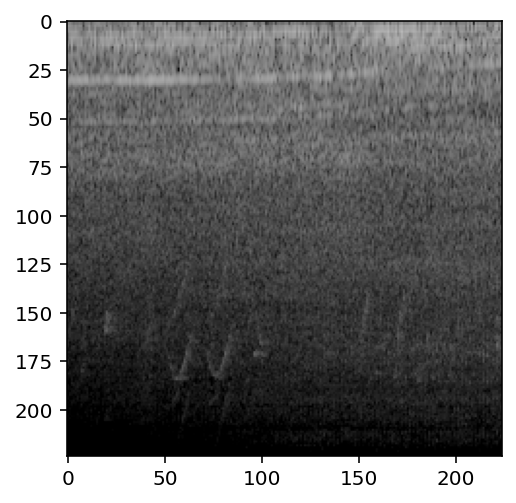

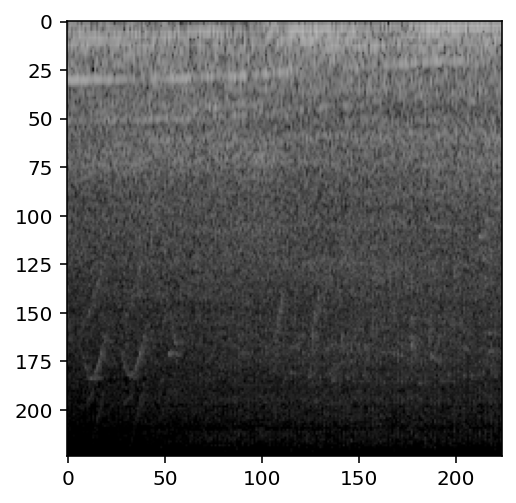

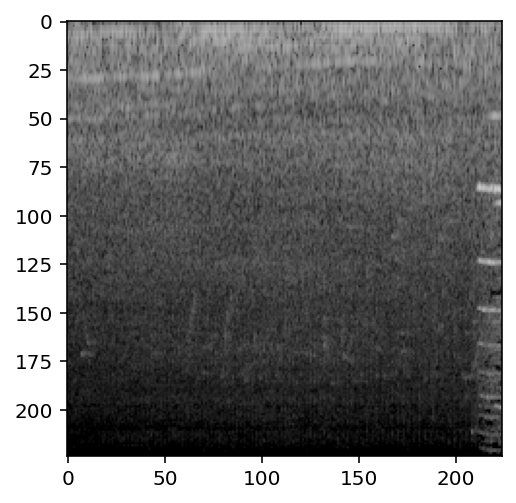

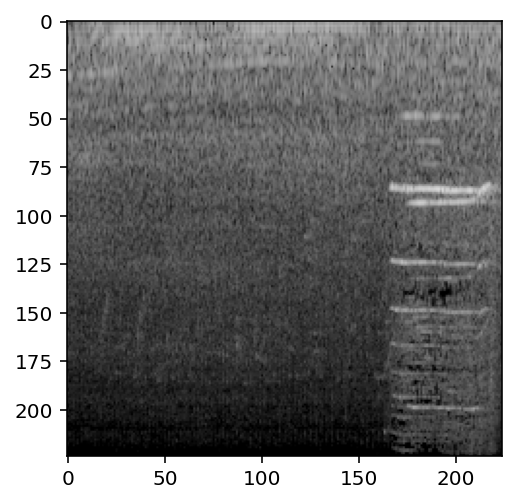

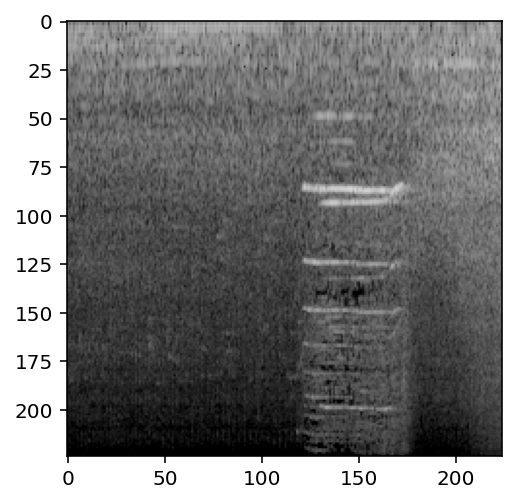

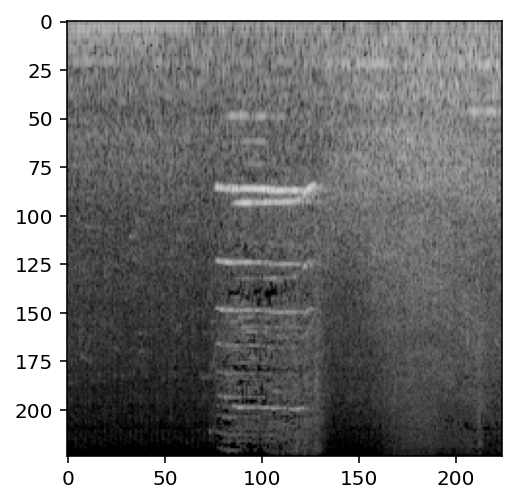

In [23]:
c=65
plt.imshow(a[0][c])
plt.show()
plt.imshow(a[0][c+1])
plt.show()
plt.imshow(a[0][c+2])
plt.show()
plt.imshow(a[0][c+3])
plt.show()
plt.imshow(a[0][c+4])
plt.show()
plt.imshow(a[0][c+5])
plt.show()

In [18]:
model = keras.models.load_model("/app/_data/models/nocall/eff0_nocall_3.h5")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [19]:
pred = model.predict(all_gen, max_queue_size=50,verbose=1,
    workers=20)

8137/8137 [==============================] - 15068s 2s/step


In [20]:
pred

array([[1.287e-02, 9.863e-01, 1.559e-04],
       [5.603e-02, 9.453e-01, 2.084e-04],
       [1.645e-05, 1.000e+00, 2.712e-05],
       ...,
       [0.000e+00, 1.000e+00, 0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00]], dtype=float16)

In [21]:
pred_df = pd.DataFrame(pred)

pred_df['row_id'] = all_gen.row_id[:len(pred_df)]

pred_df['filename'] = all_gen.filename[:len(pred_df)]

pred_df['end_sec'] = all_gen.end_sec[:len(pred_df)]

In [25]:
pred_df

,nocall,bird,bad,row_id,filename,end_sec
0,0.012871,0.986328,0.000156,XC109605_5_0,XC109605.ogg,5.0
1,0.056030,0.945312,0.000208,XC109605_6_0,XC109605.ogg,6.0
2,0.000016,1.000000,0.000027,XC109605_7_0,XC109605.ogg,7.0
3,0.023148,0.976074,0.000373,XC109605_8_0,XC109605.ogg,8.0
4,0.072876,0.931641,0.000043,XC109605_9_0,XC109605.ogg,9.0
...,...,...,...,...,...,...
3262932,0.000000,1.000000,0.000000,XC579823_38_0,XC579823.ogg,38.0
3262933,0.000000,1.000000,0.000000,XC579823_39_0,XC579823.ogg,39.0
3262934,0.000000,1.000000,0.000000,XC579823_40_0,XC579823.ogg,40.0
3262935,0.000000,1.000000,0.000000,XC579823_41_0,XC579823.ogg,41.0


In [27]:
pred_df.to_csv('/app/_data/labels_nocall/nocall_predictions_v2_3class.csv', index=False)

In [24]:
pred_df.columns=['nocall', 'bird', 'bad', 'row_id', 'filename','end_sec']
